In [19]:
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

ROOT_DIR = Path(os.path.abspath(''))

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

MODEL_DIR = ROOT_DIR.joinpath("logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [20]:
class SofasConfig(Config):
    NAME = "sofas"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    NUM_CLASSES = 1 + 1  # background + 1 class (sofa)

    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 200

    VALIDATION_STEPS = 10

config = SofasConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [21]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [32]:
from PIL import Image, ImageOps

class SofasDataset(utils.Dataset):
    def load_sofas(self, count, height, width):
        self.cache = {}

        # Add classes
        self.add_class("sofas", 1, "sofa")

        # Add images
        for i in range(count):
            datadir = Path("D:/Git/NDDS Generated/TestCapturer")
            strnumber = '0' * (6 - len(str(i))) + str(i)
            path = str(datadir.joinpath(f"{strnumber}.png"))

            self.add_image(
                "sofas", 
                image_id=i, 
                path=path,
                width=width, 
                height=height,
                sofas=["sofa"])

    def load_image(self, image_id):
        image = self._load_image(image_id, '')
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "sofas":
            return info["sofas"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        sofas = info['sofas']
        count = len(sofas)
        mask = self._load_image(image_id, '.cs')
        class_ids = np.array([1 for s in sofas])
        return mask.astype(bool), class_ids.astype(np.int32)

    def _load_image(self, number, subtype):
        datadir = Path("D:/Git/NDDS Generated/TestCapturer")
        strnumber = '0' * (6 - len(str(number))) + str(number)
        path = str(datadir.joinpath(f"{strnumber}{subtype}.png"))
        if path in self.cache.keys():
            return self.cache[path]
        image = Image.open(path).convert('RGB')
        if subtype != '':
            image = ImageOps.grayscale(image)
            data = np.expand_dims((np.asarray(image).astype(np.int32) / 255), 2)
        else:
            data = np.asarray(image).astype(np.float32)
        self.cache[path] = data
        return data

In [33]:
dataset_train = SofasDataset()
dataset_train.load_sofas(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = SofasDataset()
dataset_val.load_sofas(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

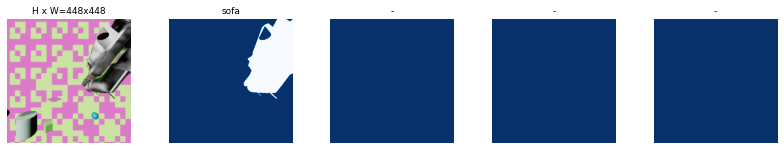

In [34]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [25]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
init_with = "none"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [27]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")   # all or heads


Starting at epoch 0. LR=0.0001

Checkpoint Path: d:\Git\Mask_RCNN\logs\sofas20210517T2213\mask_rcnn_sofas_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

KeyboardInterrupt: 

In [37]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mymodel.h5")
model.keras_model.save_weights(model_path)

In [7]:
class InferenceConfig(SofasConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  d:\Git\Mask_RCNN\logs\sofas20210516T2217\mask_rcnn_sofas_0002.h5
Re-starting from epoch 2


In [8]:
import random

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

original_image           shape: (448, 448, 3)         min:    0.00000  max:  222.00000  float32
image_meta               shape: (14,)                 min:    0.00000  max:  448.00000  int32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  448.00000  int32
gt_mask                  shape: (448, 448, 3)         min:    0.00000  max:    1.00000  bool
[[  0 215 278 448]]
(1, 4) (448, 448, 3) (1,)


AssertionError: 

In [ ]:


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

